In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from scipy.stats import boxcox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox

import warnings
warnings.filterwarnings('ignore')

/udata/jupyterhub/jupyterhub/lib64/python3.4/importlib/_bootstrap.py:321: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  return f(*args, **kwds)


In [3]:
# Зарузка данных
df = pd.read_csv("WAG_C_M.csv", sep=';', index_col=['month'], parse_dates=['month'], dayfirst=True)

In [4]:
# Основные характеристики
print(df.head(10))
print(df.shape)

            WAG_C_M
month              
1993-01-01     15.3
1993-02-01     19.1
1993-03-01     23.6
1993-04-01     30.6
1993-05-01     37.5
1993-06-01     47.4
1993-07-01     56.0
1993-08-01     65.4
1993-09-01     80.9
1993-10-01     93.0
(284, 1)


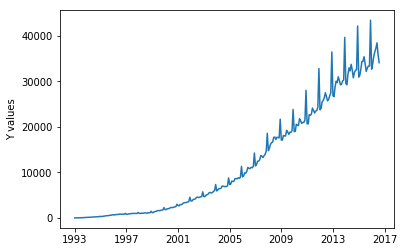

P-value 0.5946992625473273


In [5]:
# Визуальный анализ ряда
plt.plot(df.WAG_C_M)
plt.ylabel('Y values')
plt.show()
# Тест на стационарность
print('P-value', adfuller(df.WAG_C_M, regression = "ct")[1])

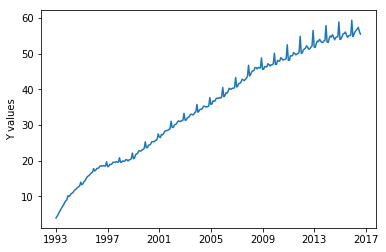

Lambda = 0.2632017541844584


In [6]:
# Ряд не стационарен, но прежде, чем брать разности, уменьшим его дисперсию
df['b_WAG_C_M'], l = boxcox(df.WAG_C_M)
plt.plot(df['b_WAG_C_M'])
plt.ylabel('Y values')
plt.show()
print('Lambda =',l)

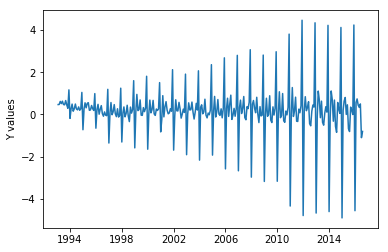

P-value 0.05702306915023561


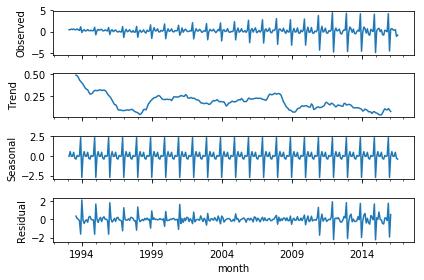

In [7]:
# По графику выше четко виден положительный тренд. Уберем его, используя первую разность
df['db_WAG_C_M'] = df.b_WAG_C_M.diff()
# Визуальный анализ ряда
plt.plot(df.db_WAG_C_M)
plt.ylabel('Y values')
plt.show()
# Тест на стационарность
print('P-value', adfuller(df.db_WAG_C_M.dropna(), regression = "ct")[1])
# Сезональность
seasonal_decompose(df.db_WAG_C_M.dropna()).plot()
plt.show()

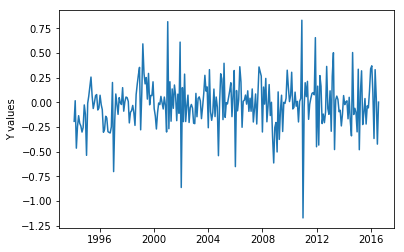

P-value 8.931137650993964e-07


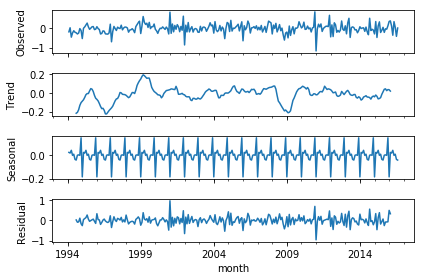

In [8]:
# Все почти стационарен, но P-value все еще выше приемлемых 5%. Мы также видим, что присутствует годичная сезонность. Уберем ее путем вычитания 12-ого лага
df['ddb_WAG_C_M'] = df.db_WAG_C_M - df.db_WAG_C_M.shift(12)
# Визуальный анализ ряда
plt.plot(df.ddb_WAG_C_M)
plt.ylabel('Y values')
plt.show()
# Тест на стационарность
print('P-value', adfuller(df.ddb_WAG_C_M.dropna(), regression = "ct")[1])
# Сезональность
seasonal_decompose(df.ddb_WAG_C_M.dropna()).plot()
plt.show()

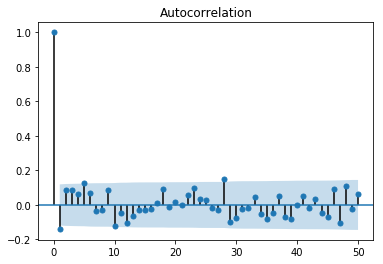

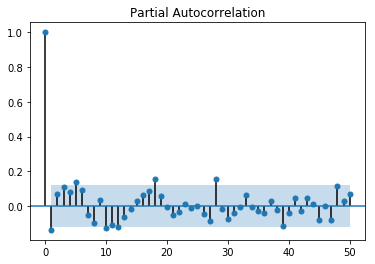

In [9]:
# Идеально. Ряд стационарен. Рассмотрим PACF и ACF
# ACF
plot_acf(df['ddb_WAG_C_M'].dropna(), lags=50)
plt.show()
# PACF
plot_pacf(df['ddb_WAG_C_M'].dropna(), lags=50)
plt.show()

In [10]:
# Примерные начальные значения: p = 1, q = 1, Q = 1, P = 2
# выберем модель по наименьшему AIC, начав цикл с 0 на всякий случай
res = [np.nan, 999999999]

for p in range(3):
    for q in range(3):
        for P in range(3):
            for Q in range(3):
                try:
                    model = SARIMAX(endog=df['b_WAG_C_M'], order=(p,1,q), seasonal_order=(P,1,Q,12))
                    model = model.fit(disp=-1)
                except:
                    continue
                if model.aic < res[1]:
                    res[0] = [p,q,P,Q]
                    res[1] = model.aic
                    print(res)



[[0, 0, 0, 1], 4.46392044310911]
[[0, 0, 1, 0], 4.2688979230629585]
[[0, 0, 2, 2], 1.8366586412271388]
[[0, 1, 0, 1], 1.5817818341974004]
[[0, 1, 1, 0], 1.170768456513752]
[[0, 1, 2, 2], -0.9500778506135106]
[[0, 2, 2, 2], -1.1704454348743667]
[[1, 0, 2, 2], -1.6748934393251478]


In [11]:
# Лучшая модель согласно AIC - SARIMA(1,1,0)(2,1,2), что соответствует ACF и PACF
model = SARIMAX(endog=df['b_WAG_C_M'], order=(res[0][0],1,res[0][1]), seasonal_order=(res[0][2],1,res[0][3],12))
model = model.fit(disp=-1)

                                 Statespace Model Results                                 
Dep. Variable:                          b_WAG_C_M   No. Observations:                  284
Model:             SARIMAX(1, 1, 0)x(2, 1, 2, 12)   Log Likelihood                   6.837
Date:                            Mon, 10 Jan 2022   AIC                             -1.675
Time:                                    14:45:34   BIC                             20.219
Sample:                                01-01-1993   HQIC                             7.103
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1402      0.052     -2.706      0.007      -0.242      -0.039
ar.S.L12       0.5211      0.271   

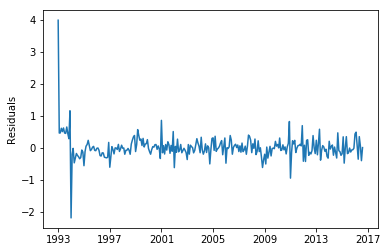

In [12]:
# Проверим остатки на автокорреляцию
print(model.summary())
# Ljung-Box тест показывает отстутствие автокорреляции в ошибках
plt.plot(model.resid)
plt.ylabel('Residuals')
plt.show()
# Трендов в ошибках на графике тоже не видно

In [13]:
# Сохраним прогнозы модели в таблицу
def invboxcox(y,l):
   if l == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(l*y+1)/l))

df['Prediction'] = invboxcox(model.fittedvalues, l)

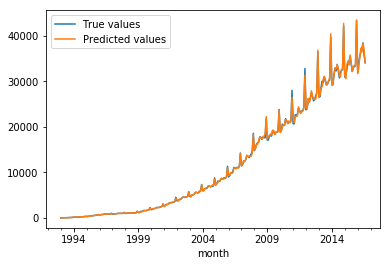

In [14]:
# Построим график для сравнения результатов
df['WAG_C_M'].plot(label='True values')
df['Prediction'].plot(label='Predicted values')
plt.legend(['True values', 'Predicted values'])
# Результаты очень близки друг к другу

2016-09-01    34972.394601
2016-10-01    35433.355682
2016-11-01    35423.365287
2016-12-01    46127.600931
2017-01-01    34392.767285
2017-02-01    35550.994580
2017-03-01    37156.625793
2017-04-01    38353.866670
2017-05-01    39044.987522
2017-06-01    40203.766205
2017-07-01    37615.557131
2017-08-01    35688.847245
2017-09-01    36514.089326
2017-10-01    36974.585810
2017-11-01    36935.276300
2017-12-01    48225.692071
2018-01-01    35906.594560
2018-02-01    37162.892189
2018-03-01    38883.382983
2018-04-01    40034.117222
2018-05-01    40786.707563
2018-06-01    41998.468526
2018-07-01    39146.600142
2018-08-01    37080.045537
2018-09-01    37947.637311
Freq: MS, dtype: float64


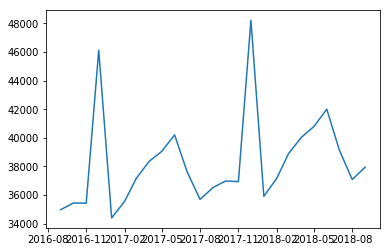

In [19]:
# Прогноз на два следующие года
predict = invboxcox(model.predict(start=284, end=284+24), l)
print(predict)
plt.plot(predict)